In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [10]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [11]:
region = "GES"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [12]:
code_bss

['03423X0056_100',
 '02706X0074_S77-20',
 '04131X0111_120',
 '04137X0009_C20',
 '04133X0006_30',
 '03786X0074_130',
 '02612X0021_S30',
 '04137X0022_S30',
 '03426X0223_140',
 '01405X0141_P50',
 '03791X0042_V50',
 '01987X0124_631-1',
 '01133X0099_PZ-1',
 '03422X0031_101',
 '02645X0038_D601',
 '01376X0149_H01',
 '01377X0211_M01',
 '01373X0132_P01',
 '04454X0033_S11',
 '04138X0005_21',
 '01996X0008_341',
 '02343X0003_561',
 '03783X0046_71',
 '02718X0039_271',
 '02726X0039_231B1',
 '01995X0103_338B1',
 '01358X0035_PC1',
 '03001X0110_SC1',
 '01996X0059_352D1',
 '01988X0050_572D1',
 '02344X0070_319D1',
 '01593X0100_F1',
 '02653X0001_F1',
 '04761X0021_F1',
 '03732X0002_F1',
 '03027X0007_F1',
 '01116X0138_F1',
 '02718X0005_G1',
 '01398X0099_GEL1',
 '02276X0050_P1',
 '01146X0070_P1',
 '03745X0021_P1',
 '03366X0021_P1',
 '03712X0012_P1',
 '03375X0013_P1',
 '03737X0013_P1',
 '03717X0004_P1',
 '01918X0006_P1',
 '02296X0038_P1',
 '03001X0112_DP1',
 '02723X0900_245R1',
 '01097X0015_SR1',
 '02603X1010

## Construction d'un dataframe

In [13]:
directory = '../data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [14]:
data

03423X0056_100  02706X0074_S77-20  04131X0111_120  \
date_mesure                                                      
1949-03-09              NaN                NaN             NaN   
1949-03-16              NaN                NaN             NaN   
1949-03-23              NaN                NaN             NaN   
1949-03-30              NaN                NaN             NaN   
1949-04-06              NaN                NaN             NaN   
...                     ...                ...             ...   
2022-05-26              NaN             -15.96             NaN   
2022-05-27              NaN             -15.95             NaN   
2022-05-28              NaN             -15.92             NaN   
2022-05-29              NaN             -15.90             NaN   
2022-05-30              NaN             -15.91             NaN   

             04137X0009_C20  04133X0006_30  03786X0074_130  02612X0021_S30  \
date_mesure                                                                  
1949-03-09              NaN            NaN             NaN             NaN   
1949-03-16              NaN            NaN             NaN             NaN   
1949-03-23              NaN            NaN             NaN             NaN   
1949-03-30              NaN            NaN             NaN             NaN   
1949-04-06              NaN            NaN             NaN             NaN   
...                     ...            ...             ...             ...   
2022-05-26              NaN            NaN             NaN             NaN   
2022-05-27              NaN            NaN             NaN             NaN   
2022-05-28              NaN            NaN             NaN             NaN   
2022-05-29              NaN            NaN             NaN             NaN   
2022-05-30              NaN            NaN             NaN             NaN   

             04137X0022_S30  03426X0223_140  01405X0141_P50  ...  \
date_mesure                                                  ...   
1949-03-09              NaN             NaN             NaN  ...   
1949-03-16              NaN             NaN             NaN  ...   
1949-03-23              NaN             NaN             NaN  ...   
1949-03-30              NaN             NaN             NaN  ...   
1949-04-06              NaN             NaN             NaN  ...   
...                     ...             ...             ...  ...   
2022-05-26              NaN             NaN             NaN  ...   
2022-05-27              NaN             NaN             NaN  ...   
2022-05-28              NaN             NaN             NaN  ...   
2022-05-29              NaN             NaN             NaN  ...   
2022-05-30              NaN             NaN             NaN  ...   

             01397X0136_PZ  01396X0346_PZ  02342X0196_PZ  03384X0037_PZ  \
date_mesure                                                               
1949-03-09             NaN            NaN            NaN            NaN   
1949-03-16             NaN            NaN            NaN            NaN   
1949-03-23             NaN            NaN            NaN            NaN   
1949-03-30             NaN            NaN            NaN            NaN   
1949-04-06             NaN            NaN            NaN            NaN   
...                    ...            ...            ...            ...   
2022-05-26             NaN            NaN            NaN            NaN   
2022-05-27             NaN            NaN            NaN            NaN   
2022-05-28             NaN            NaN            NaN            NaN   
2022-05-29             NaN            NaN            NaN            NaN   
2022-05-30             NaN            NaN            NaN            NaN   

             01397X0137_PZ  01886X0067_PZ  01397X0138_PZ  01396X0348_PZ  \
date_mesure                                                               
1949-03-09             NaN            NaN            NaN            NaN   
1949-03-16             NaN            NaN            

## Visualisation des valeurs manquantes

In [15]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

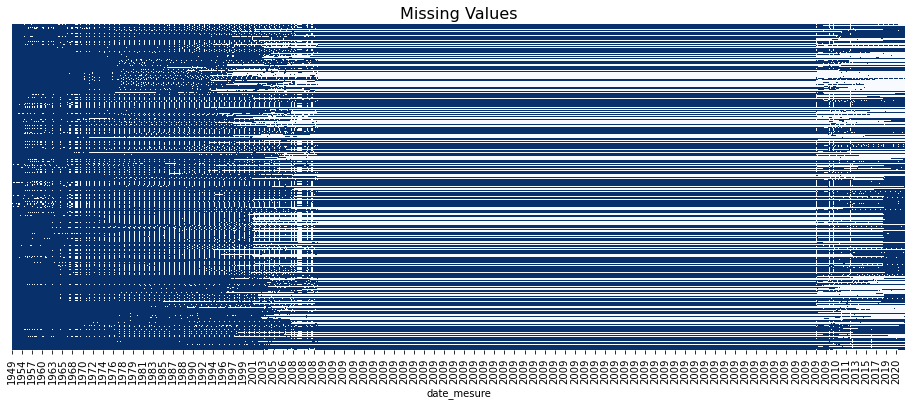

In [16]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [17]:
data_week = pd.DataFrame(data.resample('7D').mean())

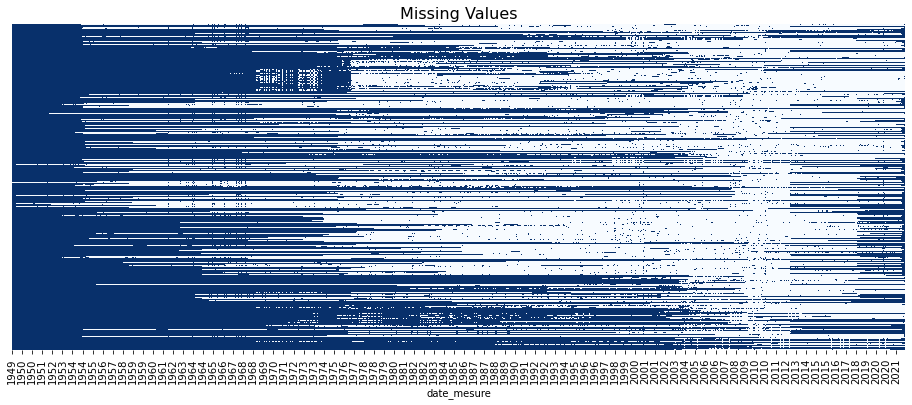

In [18]:
f_plot_nan(data_week)

In [19]:
data_week.shape

(3821, 370)

## Echelle de temps fixée après 2006 pour limiter les Nan

In [20]:
data_week_from_ = data_week.loc['01-01-2006':]

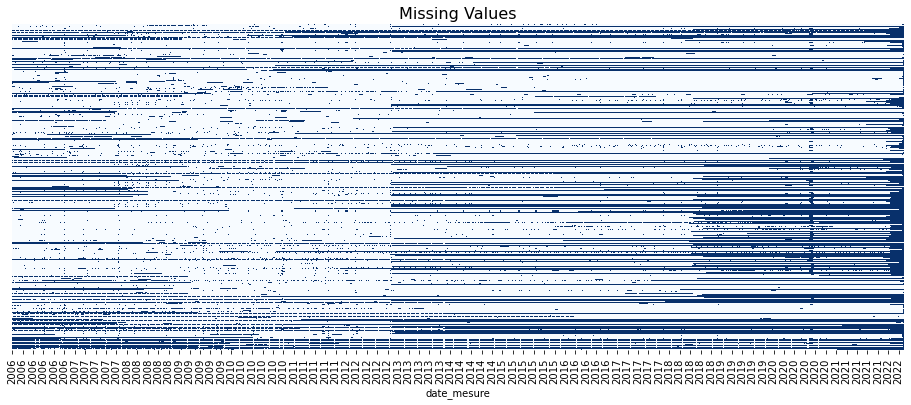

In [21]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [22]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 83354 valeurs nulles dans l'ensemble du dataframe.


In [23]:
data_wo_outliers = data_week_from_.copy()

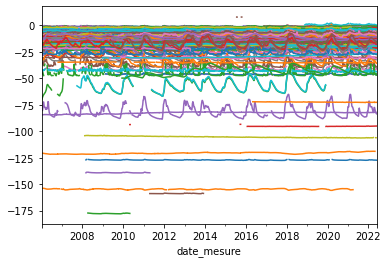

In [24]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

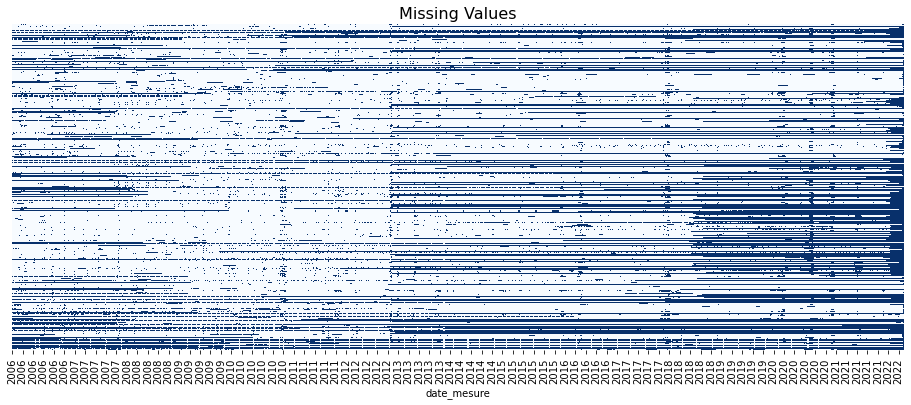

In [25]:
f_plot_nan(data_wo_outliers)

In [26]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 87333 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 10% de valeurs manquantes

In [32]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.10*data_wo_outliers.shape[0]].columns

In [33]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

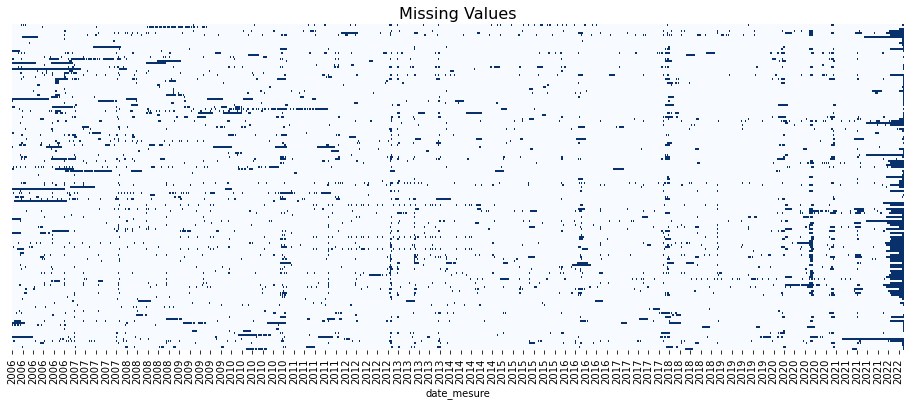

In [34]:
f_plot_nan(data_clean)

In [35]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 6121 valeurs nulles dans l'ensemble du dataframe.


In [36]:
data_clean.shape

(856, 163)

## Interpolation

In [37]:
data_interpol = data_clean.copy().interpolate('linear')

In [38]:
data_interpol.shape

(856, 163)

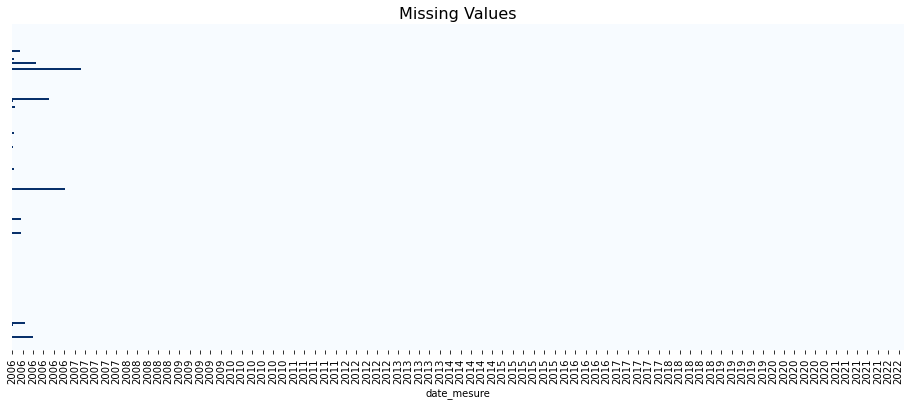

In [39]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [40]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [41]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-25 00:00:00', freq='7D')

In [42]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [43]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [44]:
data_interpol.shape

(790, 163)

In [45]:
data_interpol.shape[1]

163

## Affichage des chroniques après nettoyage

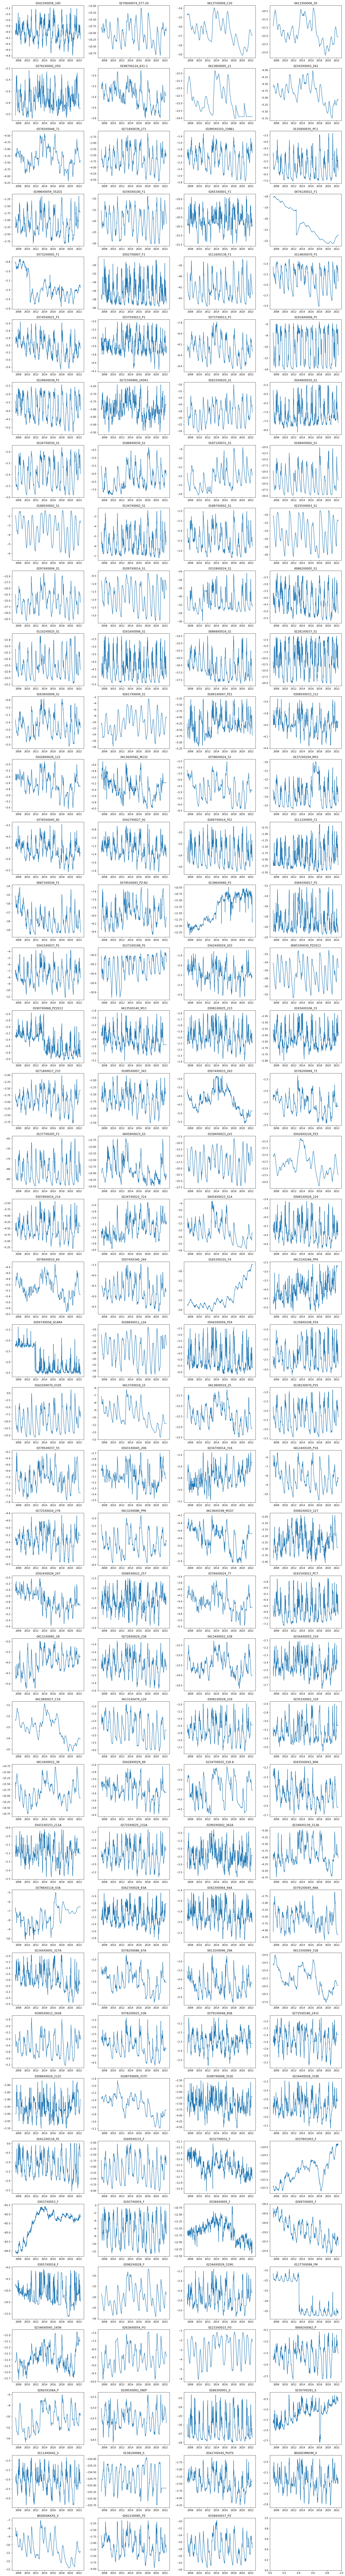

In [46]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [47]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [48]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [49]:
data_norm.head()

03423X0056_100  02706X0074_S77-20  04137X0009_C20  04133X0006_30  \
date_mesure                                                                     
2007-04-11         0.239954           0.540573        1.392762       0.484435   
2007-04-18        -0.035230           0.540573        1.440069       0.557408   
2007-04-25        -0.310414           0.621279        1.471607       0.688759   
2007-05-02        -0.310414           0.594377        1.503145       0.776326   
2007-05-09         0.136760           0.540573        1.526798       0.805515   

             03791X0042_V50  01987X0124_631-1  04138X0005_21  02343X0003_561  \
date_mesure                                                                    
2007-04-11        -1.524760          1.210033       0.589444        0.764662   
2007-04-18        -1.296553          1.046585       0.688257        0.764662   
2007-04-25        -1.068346          0.937619       0.830987        0.734180   
2007-05-02        -0.840139          0.828654       0.951758        0.680837   
2007-05-09        -0.554881          0.719689       1.017633        0.665596   

             03783X0046_71  02718X0039_271  ...  01095X0001_FAEP  \
date_mesure                                 ...                    
2007-04-11        0.403239        0.930678  ...         1.140308   
2007-04-18        0.333838        0.758116  ...         0.885723   
2007-04-25        0.162376        0.511600  ...         0.593798   
2007-05-02        0.113387        0.240432  ...         0.349396   
2007-05-09        0.105222        0.265083  ...         0.210223   

             02663X0001_S  02307X0281_S  01114X0042_S  01381X0069_S  \
date_mesure                                                           
2007-04-11       0.370461     -0.787186      0.580041     -1.253193   
2007-04-18      -0.020809     -0.958566      0.405204     -1.055680   
2007-04-25      -0.247789     -1.009345      0.323248     -0.808789   
2007-05-02      -0.380734     -1.025213      0.219438     -0.537208   
2007-05-09      -0.459636     -0.733233      0.172997     -0.487830   

             03427X0545_PUITS  BSS003MKHM_X  BSS004AXXS_X  02621X0085_PZ  \
date_mesure                                                                
2007-04-11           0.539561      1.445698      1.874123       1.087647   
2007-04-18           0.328152      0.966783      1.757541       0.878738   
2007-04-25           0.297951      0.275017      1.639890       0.696909   
2007-05-02           0.177146      0.168591      1.515822       0.530555   
2007-05-09           0.146945      0.221804      1.407797       0.437707   

             03384X0037_PZ  
date_mesure                 
2007-04-11        1.458183  
2007-04-18        1.201417  
2007-04-25        0.991772  
2007-05-02        0.800400  
2007-05-09        0.618163  

[5 rows x 163 columns]

## Sauvegarde du dataframe en csv

In [52]:
data_norm.to_csv(f"./data/{region}.csv", sep = ";")